In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
cd "drive/My Drive/Internship"

/content/drive/My Drive/Internship


In [ ]:
ls

 MSFT1.csv   msft.us.txt           'Sentiment Analysis.ipynb'  'TCS SA.ipynb'
 MSFT.csv    NSE-TATAGLOBAL11.csv   TCS.NS.csv


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 4.7MB/s 
     |████████████████████████████████| 8.7MB 19.8MB/s 
     |████████████████████████████████| 2.1MB 51.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('MSFT1.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400
...,...,...,...,...,...,...
2019-02-04,102.870003,105.800003,102.769997,105.739998,105.739998,31315100
2019-02-05,106.059998,107.269997,105.959999,107.220001,107.220001,27325400
2019-02-06,107.000000,107.000000,105.529999,106.029999,106.029999,20609800


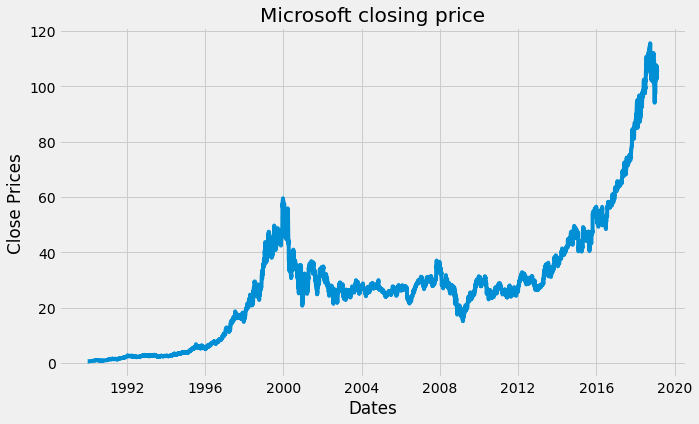

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Microsoft closing price')
plt.show()


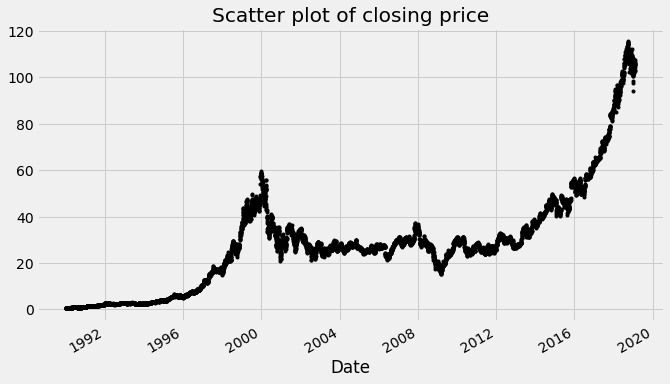

In [ ]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

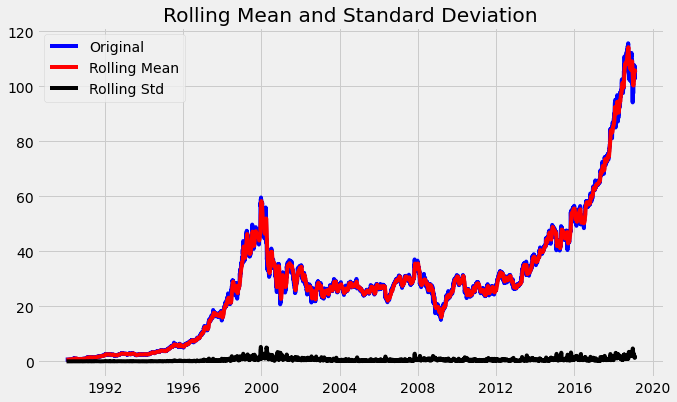

Results of dickey fuller test
Test Statistics                   1.917112
p-value                           0.998555
No. of lags used                 32.000000
Number of observations used    7301.000000
critical value (1%)              -3.431246
critical value (5%)              -2.861936
critical value (10%)             -2.566981
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

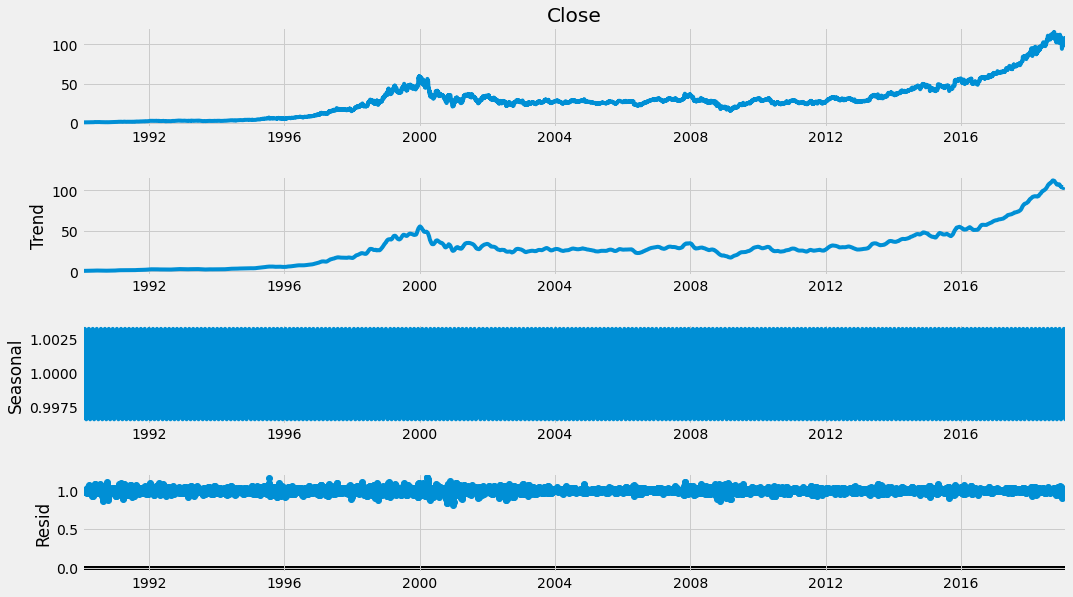

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


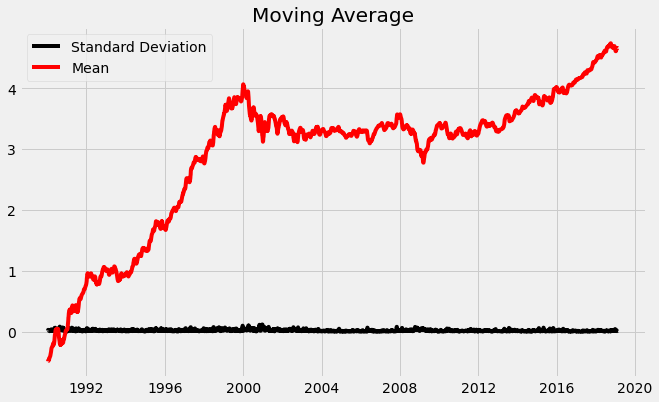

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

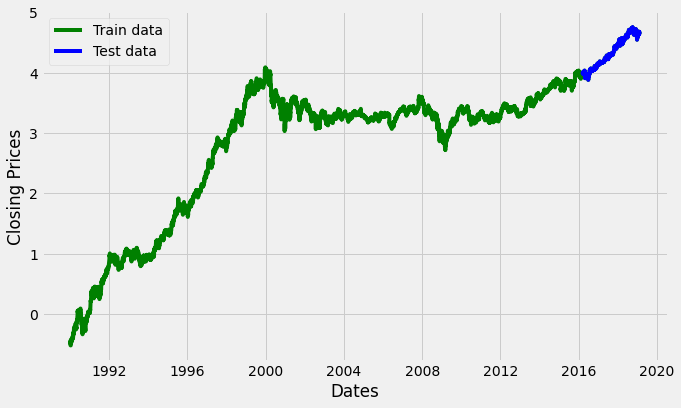

In [ ]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-32439.082, BIC=-32425.493, Time=0.596 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-32439.062, BIC=-32418.680, Time=0.538 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-32439.201, BIC=-32418.818, Time=2.642 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-32434.145, BIC=-32427.350, Time=0.321 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-32444.538, BIC=-32417.361, Time=6.686 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-32447.568, BIC=-32413.597, Time=1.705 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-32444.153, BIC=-32416.976, Time=1.813 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=-32442.477, BIC=-32401.711, Time=2.058 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-32445.260, BIC=-32404.495, Time=3.312 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-32447.150, BIC=-32413.179, Time=3.299 seco

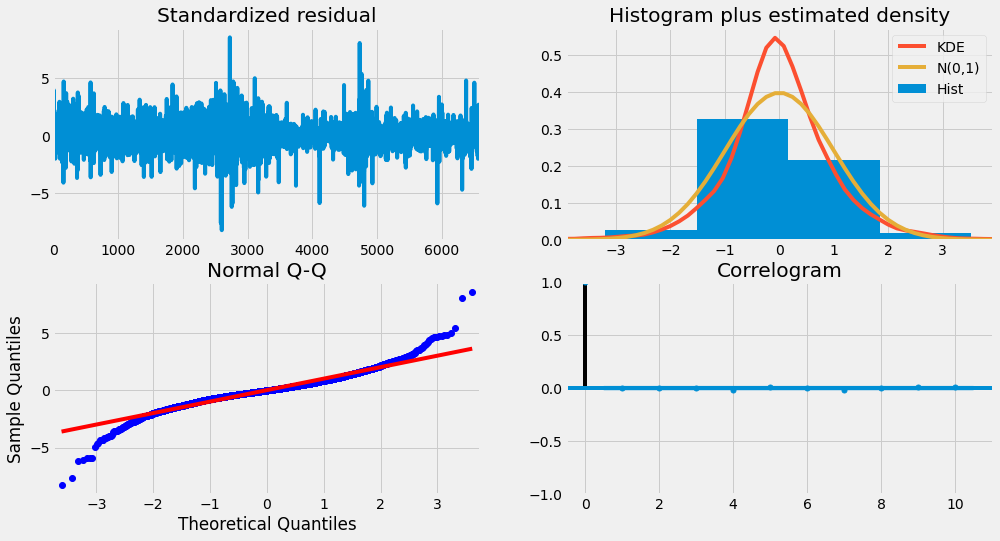

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(train_data, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6596
Model:                 ARIMA(2, 1, 1)   Log Likelihood               16228.851
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 30 Jul 2020   AIC                         -32447.702
Time:                        15:26:03   BIC                         -32413.731
Sample:                             1   HQIC                        -32435.961
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      2.936      0.003       0.000       0.001
ar.L1.D.Close     0.6039      0.135      4.466      0.000       0.339       0.869
ar.L2.D.Close    -0.0235      0.014     

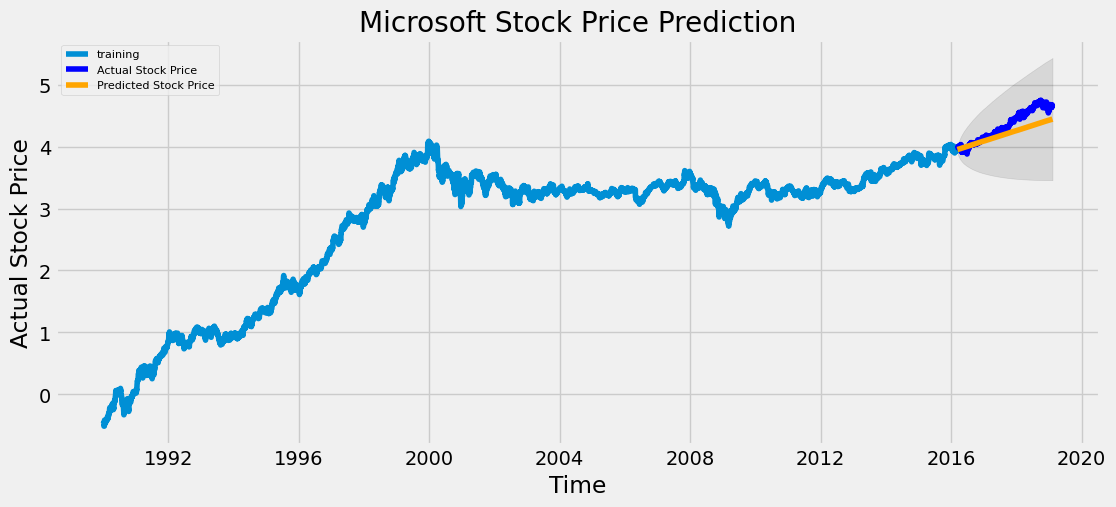

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(734, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.03184754426403192
MAE: 0.143435980088293
RMSE: 0.17845880270816544
MAPE: 0.03187026404569778
